# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
from lxml import html

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from multiprocessing import Process, Queue, Pool, Manager

from platform import python_version
print(python_version())

3.7.3


In [2]:
TRACE_NUM = 1000
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
#from HTMLParser import HTMLParser
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

#@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
html2text = html2text_bs
#html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
#@convert2unicode
def easy_tokenizer(text):
    word = ""
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ""
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
#@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s' % threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print ('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [44]:
def compression_lvl (url, html_data):
    try:
        cmpstr = zlib.compress(html_data.encode('utf-8'))
        return len(html_data.encode('utf-8')) / len(cmpstr)
    except:
        return 1
        
def title_words_num (url, html_data):
    try:
        root = html.fromstring(html_data)
        a = root.xpath('//title')[0]
        return len(a.text_content().split())
    except:
        return 0
    
def words_count(word, words, words_num):
    try:
        answer = words_num.count(word) / words_num
    except:
        answer = 0
    return answer

def calc_features(url, html_data):
    words = list(html2word(html_data))
    words_num = len(words)
    total_len = 0
    for word in words:
        total_len += len(word)
    avg_word_len = total_len / words_num
    answer = [words_num, avg_word_len]

    additional_futures = [title_words_num,
                         compression_lvl]
    for f in additional_futures:
        answer.append(f(url, html_data))
        
    words_to_find = ['скачать', 'знакомство']
    for word in words_to_find:
        answer.append(words_count(word, words, words_num))
        
    answer.append(len(url))
    
    return answer

In [11]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print (test_features)

[6, 3.5, 2, 1.028169014084507, 0.0, 0.0]


In [49]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

workers_num = 4

def process_line(i, line, calc_features_f, res_queue):
    parts = line.strip().split('\t')
    url_id = int(parts[0])                                        
    mark = bool(int(parts[1]))                    
    url = parts[2]
    pageInb64 = parts[3]
    html_data = base64.b64decode(pageInb64).decode("utf-8", errors='ignore')
    features = calc_features_f(url, html_data)
    res_queue.put(DocItem(url_id, mark, url, features))
    trace(i)
    
def mp_read_csv(input_file_name, calc_features_f):
    pool = Pool(processes=workers_num)
    m = Manager()
    res_queue = m.Queue()
    jobs = []
    
    with gzip.open(input_file_name, 'rt') if input_file_name.endswith('gz') else open(input_file_name, 'rt')  as input_file:            
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            jobs.append(pool.apply_async(process_line, (i, line, calc_features_f, res_queue)))
            
    for job in jobs:
        job.get()
        
    trace(i,1)
        
    while not res_queue.empty():
        yield res_queue.get()
        
def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    from random import random
    i_spam = 0
    
    with gzip.open(input_file_name, 'rt') if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline() 
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64).decode("utf-8", errors='ignore')
            features = calc_features_f(url, html_data)
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [45]:
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
train_docs = list(mp_read_csv(TRAIN_DATA_FILE, calc_features))

17:22:14 INFO:Complete items 00000
17:22:35 INFO:Complete items 01000
17:22:50 INFO:Complete items 02000
17:23:08 INFO:Complete items 03000
17:23:25 INFO:Complete items 04000
17:23:45 INFO:Complete items 05000
17:24:03 INFO:Complete items 06000
17:24:20 INFO:Complete items 07000
17:24:21 INFO:Complete items 07043


/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


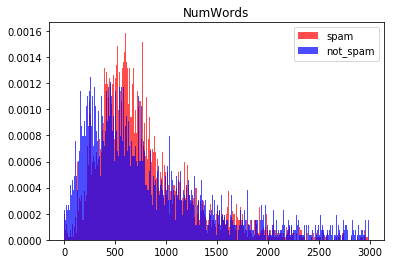

In [37]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

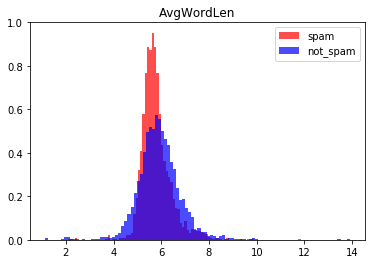

In [38]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

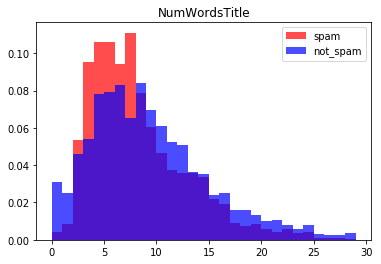

In [39]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [39]:
X = []
for doc in train_docs:
    X.append(doc.features)

In [44]:
y = []
for doc in train_docs:
    y.append(doc.is_spam)

****ДАТА СОСАЕНС НАЧИНАЕТСЯ ТУТ****

In [40]:
DocData = namedtuple('DocData', ['url_id', 'mark',
                                 'url', 'html_data', 'html_words'])
html_data_bs = []
input_file_name = 'kaggle_train_data_tab.csv'
with gzip.open(input_file_name, mode='rt') if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
    headers = input_file.readline() 
    for i, line in enumerate(input_file):
        trace(i)
        parts = line.strip().split('\t')
        url_id = int(parts[0])                                        
        mark = bool(int(parts[1]))                    
        url = parts[2]
        pageInb64 = parts[3]
        html_data = base64.b64decode(pageInb64).decode("utf-8", errors='ignore')
        words = list(html2word(html_data))
        html_data_bs.append(DocData(url_id, mark, url, html_data, words))
    trace(i,1)

17:09:18 INFO:Complete items 00000
17:09:48 INFO:Complete items 01000
17:10:15 INFO:Complete items 02000
17:10:45 INFO:Complete items 03000
17:11:14 INFO:Complete items 04000
17:11:50 INFO:Complete items 05000
17:12:23 INFO:Complete items 06000
17:12:57 INFO:Complete items 07000
17:12:58 INFO:Complete items 07043


In [42]:
spam_data_url_len = []
not_spam_data_url_len = []
for i, data in enumerate(html_data_bs):
    trace(i)
    if data[1]:
        spam_data_url_len.append(len(data[2]))
    else:
        not_spam_data_url_len.append(len(data[2]))
trace(i, 1)

17:14:58 INFO:Complete items 00000
17:14:58 INFO:Complete items 01000
17:14:58 INFO:Complete items 02000
17:14:58 INFO:Complete items 03000
17:14:58 INFO:Complete items 04000
17:14:58 INFO:Complete items 05000
17:14:58 INFO:Complete items 06000
17:14:58 INFO:Complete items 07000
17:14:58 INFO:Complete items 07043


/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


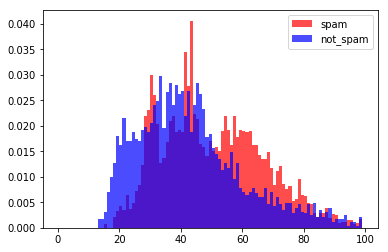

In [43]:
s_data = spam_data_url_len
n_data = not_spam_data_url_len
bins = range(0, 100, 1)
plt.hist(s_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(n_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [47]:
class Classifier:
    
    def __init__(self):
        self.params = {'max_depth' : range(1, 100, 2),
                  'criterion' : ['gini', 'entropy'],
                  'splitter' : ['best', 'random'],
                  'max_features' : ['auto', 'log2']}
                  #'min_impurity_decrease' : np.logspace(-5, -9, num=10, base=10).append(0)}
            
        self.best_clf = None

    def predict(self, doc): 
        return int(self.best_clf.predict(np.reshape(doc.features, (1,-1)))[0])
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):
        l_y = len(docs)
        l_x = len(docs[0].features)
        X = np.ndarray((l_y, l_x))
        y = np.ndarray(l_y)
        for i, doc in enumerate(docs):
            X[i,:] = doc.features
            y[i] = doc.is_spam
        
        clf = GridSearchCV(DecisionTreeClassifier(), self.params, n_jobs=-1, cv=10)
        clf.fit(X, y)
        self.best_clf = clf.best_estimator_
        print(clf.best_score_)

In [48]:
classifier = Classifier()
classifier.train(train_docs)

0.7744179443498013


In [21]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

6

In [ ]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[3]])

17:26:32 INFO:Complete items 00000
17:26:32 INFO:Complete items 00000
17:27:47 INFO:Complete items 01000
17:27:47 INFO:Complete items 01000
17:28:58 INFO:Complete items 02000
17:28:58 INFO:Complete items 02000
17:29:43 INFO:Complete items 03000
17:29:43 INFO:Complete items 03000
17:30:25 INFO:Complete items 04000
17:30:25 INFO:Complete items 04000
17:31:04 INFO:Complete items 05000
17:31:04 INFO:Complete items 05000
17:32:12 INFO:Complete items 06000
17:32:12 INFO:Complete items 06000
17:32:53 INFO:Complete items 07000
17:32:53 INFO:Complete items 07000
17:33:35 INFO:Complete items 08000
17:33:35 INFO:Complete items 08000
17:34:19 INFO:Complete items 09000
17:34:19 INFO:Complete items 09000
17:35:38 INFO:Complete items 10000
17:35:38 INFO:Complete items 10000
17:36:19 INFO:Complete items 11000
17:36:19 INFO:Complete items 11000
